import pandas as pd
from scipy.stats import ttest_ind
import random
import numpy as np

%pylab inline

Independently Distributed
-------------------------------

"IID" or independtly and identically distributed is one of those assumptions underpinning common statistical methods that doesn's always get checked. Unfortunately, this can lead to over-optimistic estimates of treatment effects. 

In [2]:
unbiased_pvals = []
def unbiased(n=100):
    for i in range(n):
        t = np.random.poisson(list(np.random.gamma(4, 1, 500)))
        c = np.random.poisson(list(np.random.gamma(4, 1, 500)))
        unbiased_pvals.append(ttest_ind(t, c)[1])

In [3]:
unbiased_pvals = []
unbiased(100)

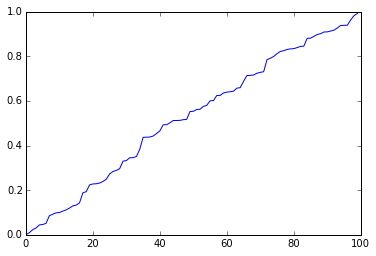

In [4]:
plot(sorted(unbiased_pvals))

In [5]:
biased_pvals = []
def biased(n=100):
    for i in range(n):
        t = np.random.poisson(list(np.random.gamma(4, 1, 100)) * 5)
        c = np.random.poisson(list(np.random.gamma(4, 1, 100)) * 5)
        biased_pvals.append(ttest_ind(t, c)[1])

In [6]:
biased_pvals = []
biased(100)

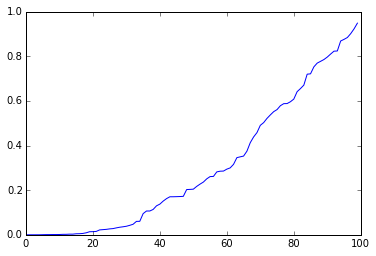

In [7]:
plot(sorted(biased_pvals))

C:\Anaconda\lib\site-packages\matplotlib\cbook.py:137: MatplotlibDeprecationWarning: The "loc" positional argument to legend is deprecated. Please use the "loc" keyword instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


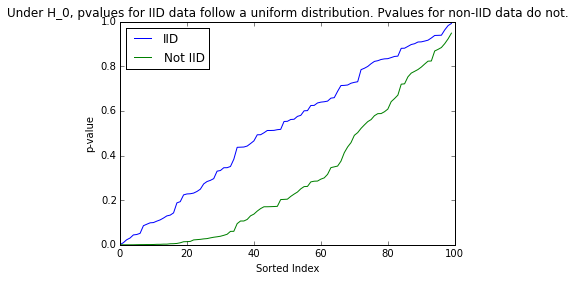

In [8]:
plot(sorted(unbiased_pvals))
plot(sorted(biased_pvals))
legend(["IID", "Not IID"], 'upper left')
xlabel("Sorted Index")
ylabel("p-value")
title("Under H_0, pvalues for IID data follow a uniform distribution. Pvalues for non-IID data do not.")

1100